# imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from argparse import Namespace
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import albumentations as A

from transformers import get_cosine_schedule_with_warmup

from tqdm.notebook import tqdm

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    !pip install -q /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl
    
from torchsummary import summary

torch.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

'2.0.0'

In [2]:
!pip -q install segmentation_models_pytorch


import segmentation_models_pytorch as smp


print(f"Segmentation Models version: {smp.__version__}")

Segmentation Models version: 0.3.3


# configs

In [3]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
else:
    BASE_DIR =  'data'

In [4]:
configs = Namespace(
    base_dir= Path(BASE_DIR),

    train = True,
    train_aug = True,

    batch_size= 16,
    epochs= 10,

    encoder = 'resnet34',
    weights= 'imagenet',
    classes= ['contrail'],
    activation= None,

    img_size= 256,

    num_worers= 2,
    shuffle= True,

    warmup = 0,
    lr=3e-3,
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),

)

In [5]:
# transform_size = A.Compose([
#     A.Resize(256, 256, interpolation=cv2.INTER_LANCZOS4, always_apply=True)
# ])

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.75, 1.0), p=0.6)
])

# load data

In [6]:
def get_paths(data_type):

    ids_list = os.listdir(os.path.join(configs.base_dir, data_type))

    df = pd.DataFrame(ids_list, columns=['record_id'])

    df['path'] = os.path.join(configs.base_dir, data_type ) +"/"+ df['record_id'].astype(str)

    return df

train_df = get_paths('train')
val_df = get_paths('validation')

In [7]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, train=True, transforms=None):
        self.df = df  # Initialize the instance variable df to store the DataFrame.
        self.trn = train  # Initialize the instance variable trn to indicate if it is a training dataset.
        self.transforms = transforms  # Initialize the instance variable transforms to store the transforms.

    def read_record(self, directory):

        record_data = {}  # Create a dictionary to store the record data.
        for x in [
            "band_11",
            "band_14",
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))  # Load data for each band and store it in the dictionary.

        if self.trn:
            record_data["mask"] = np.load(os.path.join(directory, "human_pixel_masks.npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Normalize data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def get_false_color(self, record_data):

        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        N_TIMES_BEFORE = 4
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]

        if self.trn:
            mask_img = record_data["mask"]

            return img, mask_img
        
        return img

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        data = self.read_record(con_path)  # dictionary with keys: band_11, band_14, band_15 and values: numpy arrays (height, width, channels)

        if self.trn:
            img, mask_img = self.get_false_color(data)

            if configs.train_aug:
                if self.transforms is not None:
                    
                    augmented = self.transforms(image=img, mask=mask_img)
                    img = augmented['image']
                    mask_img = augmented['mask']

            img = torch.tensor(img).float()
            mask_img = torch.tensor(mask_img).float()

            img = img.permute(2, 0, 1)
            mask_img = mask_img.permute(2, 0, 1)

            return img, mask_img
        
        img = self.get_false_color(data)
        
        img = torch.tensor(img).float()

        img = img.permute(2, 0, 1)
        return img
    

    def __len__(self):
        return len(self.df)


In [8]:
train_ds = ContrailsDataset(
        train_df,
        train = True,
        transforms = train_transform
    )

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True, num_workers = configs.num_worers, pin_memory=True, prefetch_factor=4 )

val_ds = ContrailsDataset(
        val_df,
        train = True,
        transforms = None
    )

val_dl = DataLoader(val_ds, batch_size=configs.batch_size, num_workers = configs.num_worers, pin_memory=True, prefetch_factor=4 )

In [9]:
img, label = next(iter(train_dl))
img.shape, label.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

In [10]:
img, label = next(iter(val_dl))
img.shape, label.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

# Architecture

In [11]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super(UNet, self).__init__()
        
        self.cfg = cfg
        self.training = True
        
        self.model = smp.Unet(
            encoder_name=cfg.encoder, 
            encoder_weights=cfg.weights, 
            decoder_use_batchnorm=True,
            classes=len(cfg.classes), 
            activation=cfg.activation,
        )
    
    def forward(self, imgs):
        
        x = imgs

        logits = self.model(x)

        return logits
        
        # if Config.image_size != 256:
        #     logits = F.interpolate(logits, size=(256, 256), mode='nearest-exact')


In [12]:
summary(UNet(configs).to(configs.device), input_size=(3, 256, 256))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 275MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# Training

In [13]:
class Dice(nn.Module):
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.0 *intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
dice = Dice()

In [14]:
class MyTrainer:
    def __init__(self, model, optimizer, loss_fn, lr_scheduler):
        self.validation_losses = []
        self.batch_losses = []
        self.epoch_losses = []
        self.learning_rates = []
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self._check_optim_net_aligned()

    # Ensures that the given optimizer points to the given model
    def _check_optim_net_aligned(self):
        assert self.optimizer.param_groups[0]['params'] == list(self.model.parameters())

    # Trains the model
    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 10,
            eval_every: int = 1,
            ):
  
        for e in range(epochs):
            print("New learning rate: {}".format(self.lr_scheduler.get_last_lr()))
            self.learning_rates.append(self.lr_scheduler.get_last_lr()[0])

            # Stores data about the batch
            batch_losses = []
            sub_batch_losses = []

            for i, data in enumerate(train_dataloader):
                
                self.model.train()
                torch.set_grad_enabled(True)
                if (i+1) % 150 == 0:
                    print(f'epoch: {e} batch: {i}/{len(train_dataloader)} loss: {torch.Tensor(sub_batch_losses).mean()}')
                    sub_batch_losses.clear()
                # Every data instance is an input + label pair
                images, mask = data
                
                if torch.cuda.is_available():
                    images = images.cuda()
                    mask = mask.cuda()

                # Zero your gradients for every batch!
                self.optimizer.zero_grad()
                # Make predictions for this batch
                outputs = self.model(images)
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, mask)
                loss.backward()
                # Adjust learning weights
                self.optimizer.step()

                # Saves data
                self.batch_losses.append(loss.item())
                batch_losses.append(loss)
                sub_batch_losses.append(loss)
            

            # Adjusts learning rate
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            # Reports on the path
            mean_epoch_loss = torch.Tensor(batch_losses).mean()
            self.epoch_losses.append(mean_epoch_loss.item())
            print('Train Epoch: {} Average Loss: {:.6f}'.format(e, mean_epoch_loss))

            # Reports on the training progress
            if (e + 1) % eval_every == 0:
                torch.save(self.model.state_dict(), "model_checkpoint_e" + str(e) + ".pt")
                with torch.no_grad():
                
                    self.model.eval()
                    torch.set_grad_enabled(False)
                    losses = []
                    for i, data in enumerate(test_dataloader):
                        # Every data instance is an input + label pair
                        images, mask = data

                        if torch.cuda.is_available():
                            images = images.cuda()
                            mask = mask.cuda()

                        output = self.model(images)
                        loss = self.loss_fn(output, mask)
                        losses.append(loss.item())
                        
                    avg_loss = torch.Tensor(losses).mean().item()
                    self.validation_losses.append(avg_loss)
                    print("Validation loss after", (e + 1), "epochs was", round(avg_loss, 4))

In [15]:
def get_optimizer(lr, params):
    
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=0)
    
    return model_optimizer

In [16]:
def get_scheduler(cfg, optimizer, total_steps):
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps= cfg.warmup * (total_steps // cfg.batch_size),
        num_training_steps= cfg.epochs * (total_steps // cfg.batch_size)
    )
    return scheduler

In [17]:
train = True

if train:
    model = UNet(configs).to(configs.device)

    total_steps = len(train_ds)

    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(100))
    criterion = smp.losses.DiceLoss(mode='binary')
    optimizer = get_optimizer(params=model.parameters(), lr=configs.lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

    trainer = MyTrainer(model, optimizer, criterion, scheduler)
    trainer.fit(train_dl, val_dl, epochs=configs.epochs)

else:
    
    model = UNet(configs).to(configs.device)
    model.load_state_dict(torch.load(os.path.join(configs.base_dir, 'model_checkpoint_e7.pt')))
    model.eval()
    model.to(configs.device)

New learning rate: [0.001]
epotch: 0 batch: 149/1284 loss: 0.8429468274116516
epotch: 0 batch: 299/1284 loss: 0.6406505107879639
epotch: 0 batch: 449/1284 loss: 0.6075247526168823
epotch: 0 batch: 599/1284 loss: 0.5949986577033997
epotch: 0 batch: 749/1284 loss: 0.5641372799873352
epotch: 0 batch: 899/1284 loss: 0.5866422653198242
epotch: 0 batch: 1049/1284 loss: 0.588011622428894
epotch: 0 batch: 1199/1284 loss: 0.5665090084075928
Train Epoch: 0 Average Loss: 0.619188
Validation loss after 1 epochs was 0.6875
New learning rate: [0.0008]
epotch: 1 batch: 149/1284 loss: 0.5422141551971436
epotch: 1 batch: 299/1284 loss: 0.53758305311203
epotch: 1 batch: 449/1284 loss: 0.5253624320030212
epotch: 1 batch: 599/1284 loss: 0.5244554281234741
epotch: 1 batch: 749/1284 loss: 0.546474277973175
epotch: 1 batch: 899/1284 loss: 0.5383315086364746
epotch: 1 batch: 1049/1284 loss: 0.5188996195793152
epotch: 1 batch: 1199/1284 loss: 0.5109946727752686
Train Epoch: 1 Average Loss: 0.531668
Validation 

# Training Progress

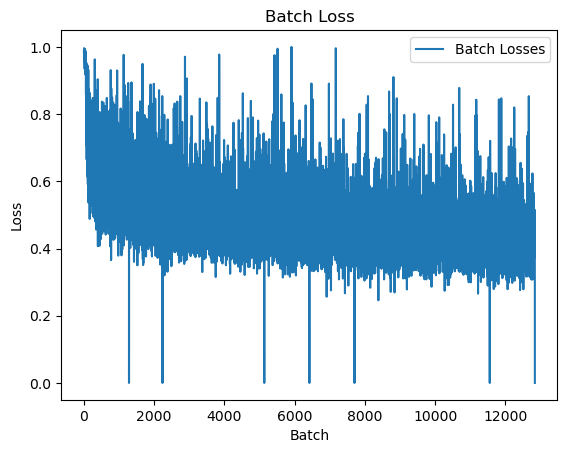

In [18]:
if train:
    df_data = pd.DataFrame({'Batch Losses': trainer.batch_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Batch Loss')
    plt.show()

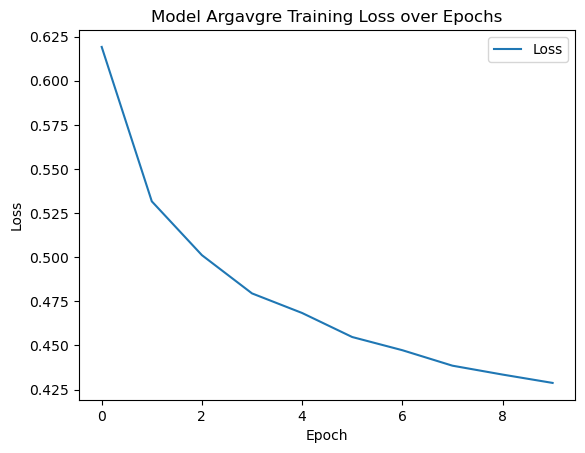

In [19]:
if train:
    df_data = pd.DataFrame({'Loss': trainer.epoch_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Argavgre Training Loss over Epochs')
    plt.show()

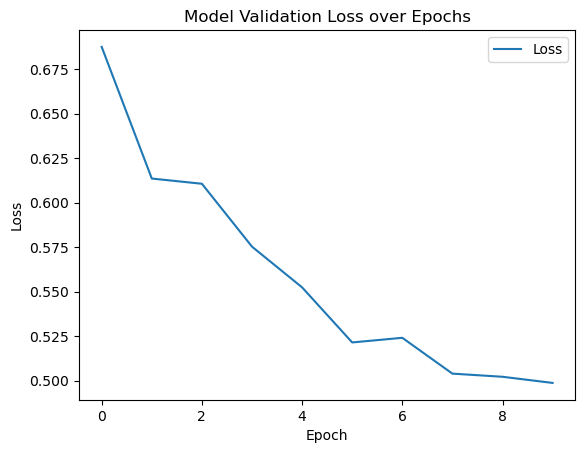

In [20]:
if train:
    df_data = pd.DataFrame({'Loss': trainer.validation_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Validation Loss over Epochs')
    plt.show()

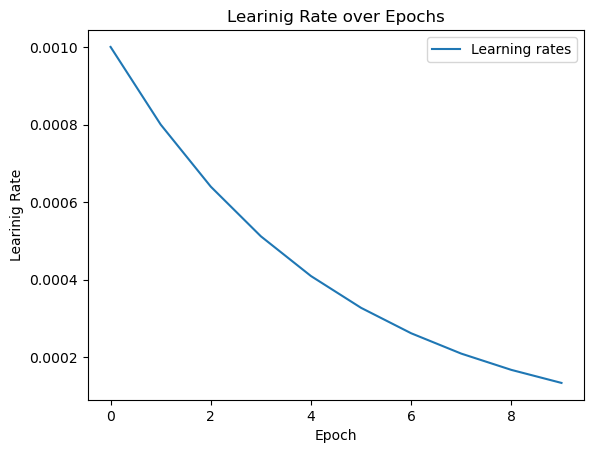

In [21]:
if train:
    df_data = pd.DataFrame({'Learning rates': trainer.learning_rates})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Learinig Rate')
    plt.title('Learinig Rate over Epochs')
    plt.show()

# Optimum Threshold

In [22]:
class DiceThresholdTester:
    
    def __init__(self, model: nn.Module, data_loader: torch.utils.data.DataLoader):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []
        
    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()
        
        for images, mask_true in self.data_loader:
            if torch.cuda.is_available():
                images = images.cuda()

            mask_pred = sigmoid(model.forward(images))

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())
            
        self.cumulative_mask_pred = np.concatenate(self.cumulative_mask_pred, axis=0)
        self.cumulative_mask_true = np.concatenate(self.cumulative_mask_true, axis=0)

        self.cumulative_mask_pred = torch.flatten(torch.from_numpy(self.cumulative_mask_pred))
        self.cumulative_mask_true = torch.flatten(torch.from_numpy(self.cumulative_mask_true))
    
    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

In [23]:
if train:
    dice_threshold_tester = DiceThresholdTester(model, val_dl)
    dice_threshold_tester.precalculate_prediction()

In [24]:
if train:
    thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

    optim_threshold = 0.98
    best_dice_score = -1

    thresholds = []
    dice_scores = []

    for t in thresholds_to_test:
        dice_score = dice_threshold_tester.test_threshold(t)
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            optim_threshold = t

        thresholds.append(t)
        dice_scores.append(dice_score)

    print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
    df_threshold_data = pd.DataFrame({'Threshold': thresholds, 'Dice Score': dice_scores})
else:
    optim_threshold = 0.28

Best Threshold: 0.28 with dice: 0.5479595412289552


In [25]:
if train:
    df_threshold_data.tail(), df_threshold_data.shape

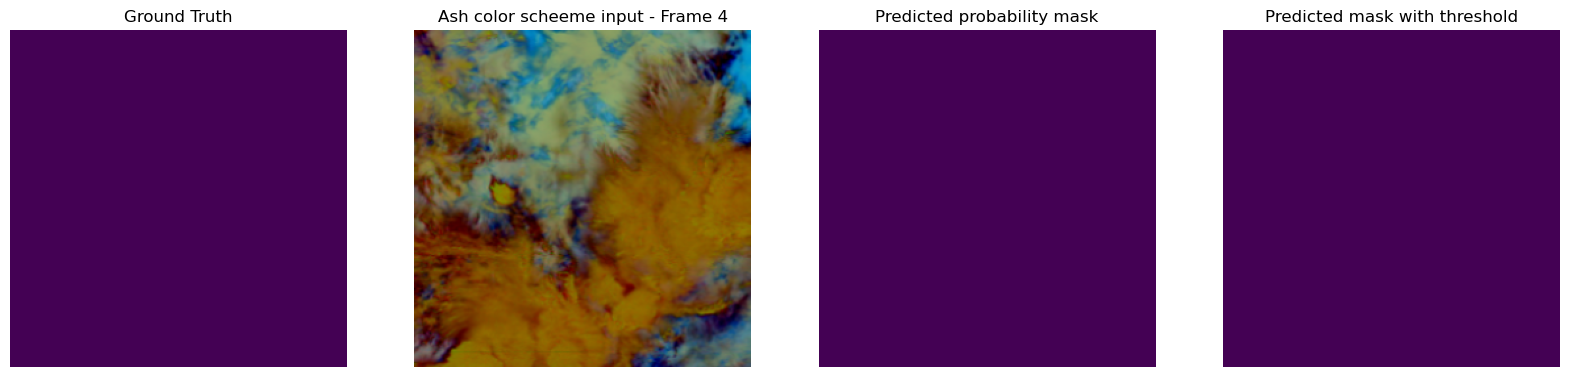

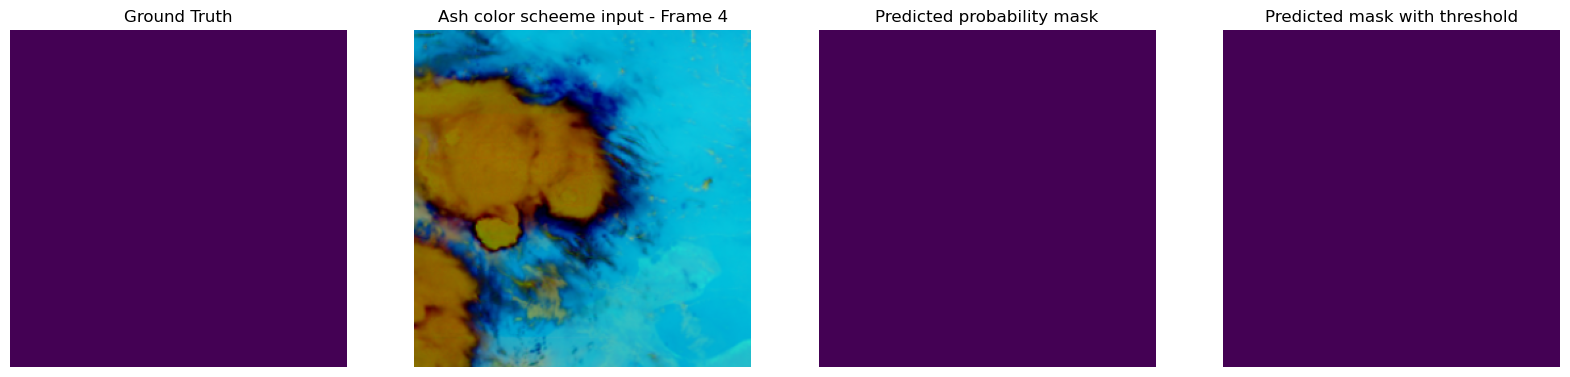

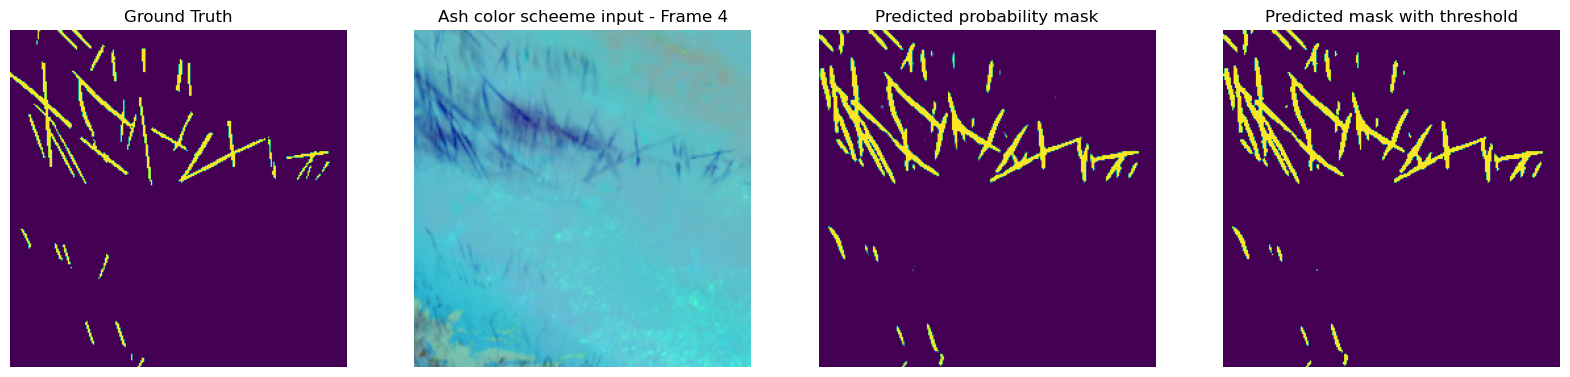

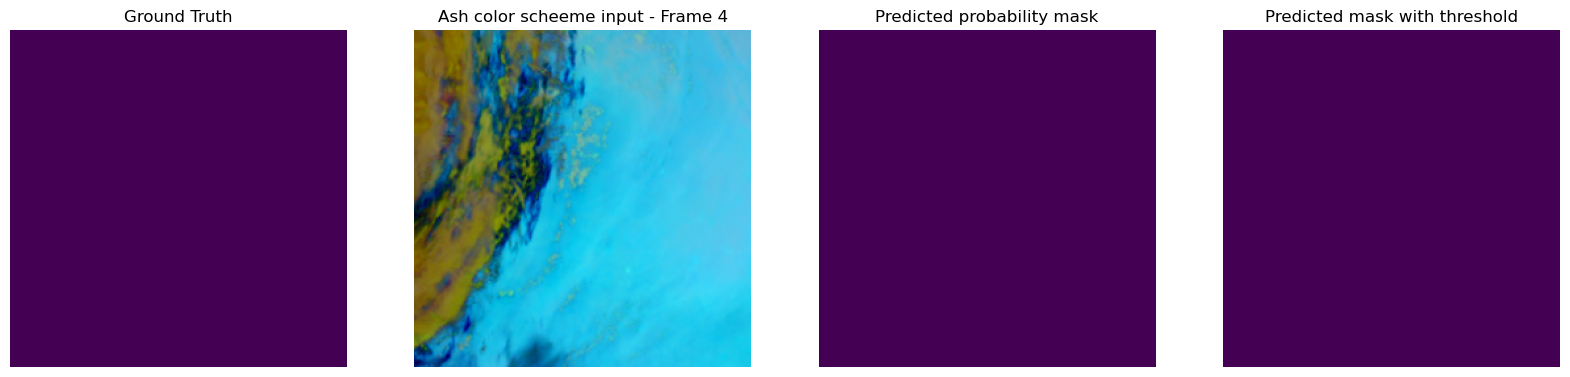

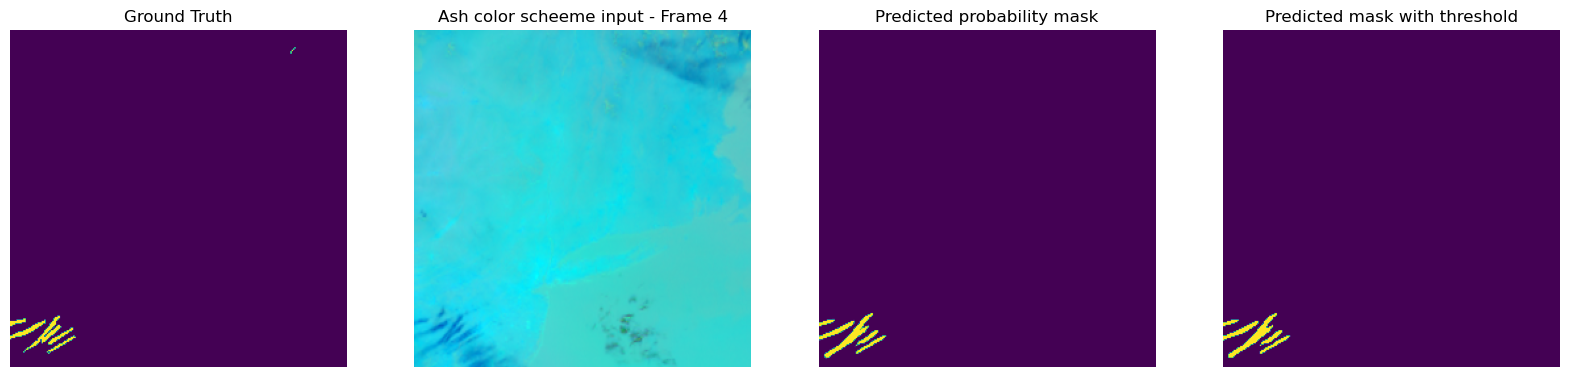

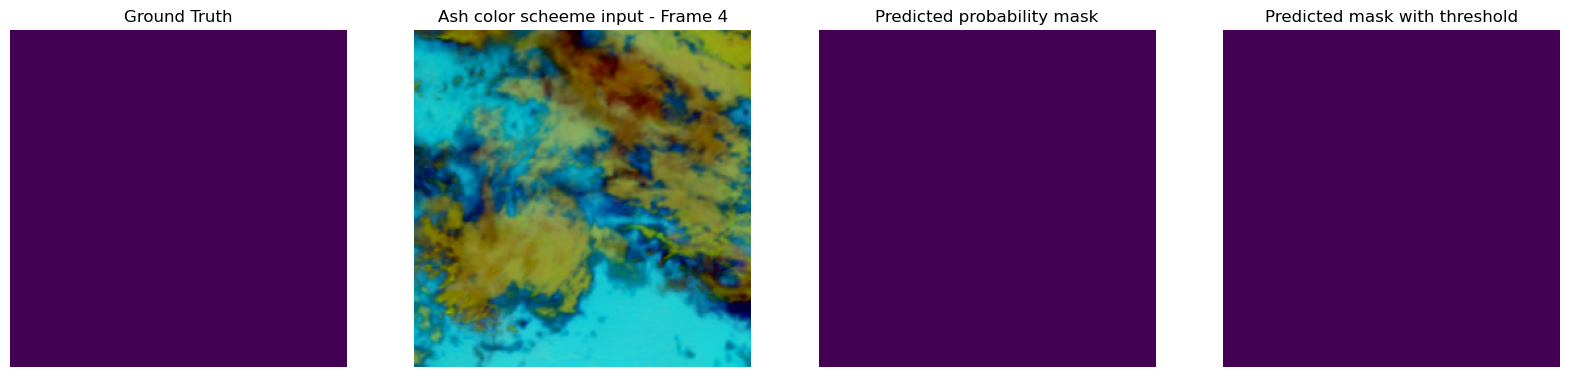

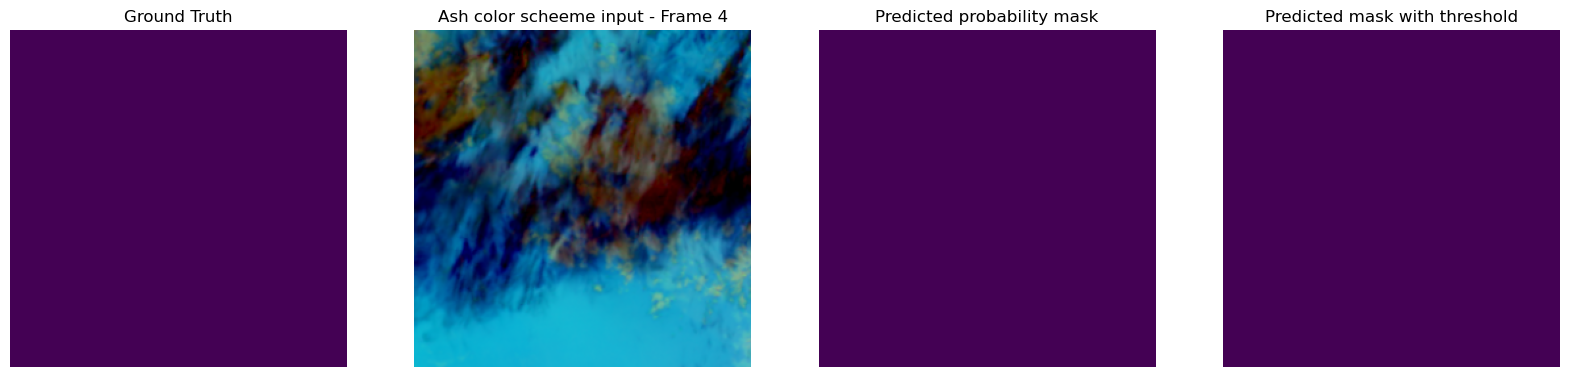

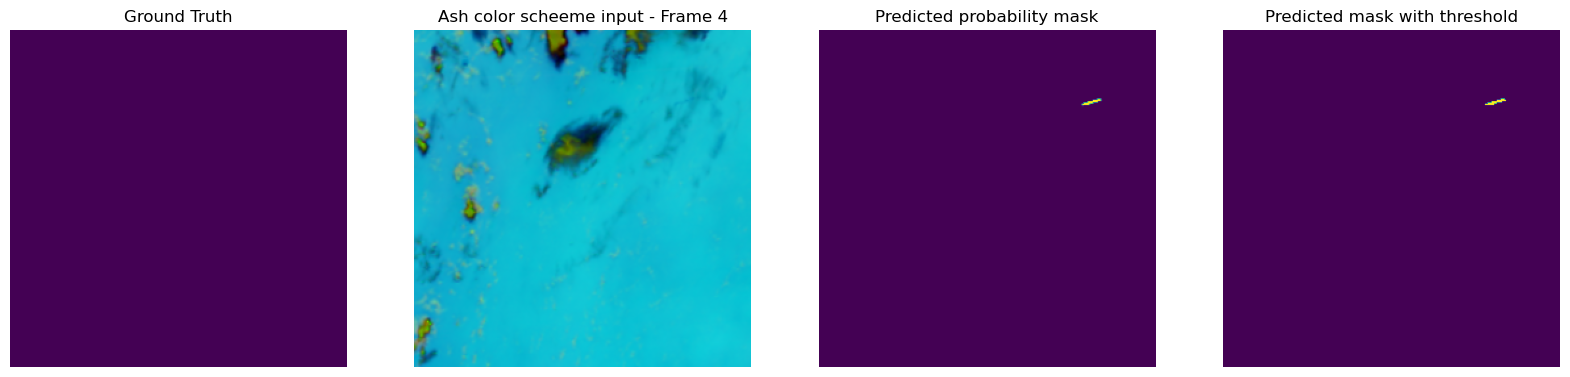

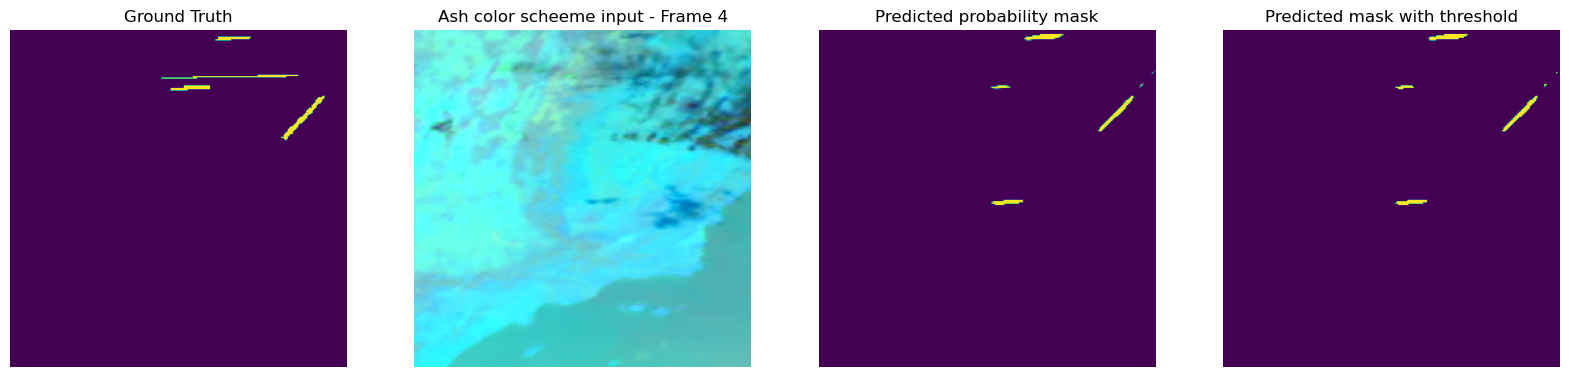

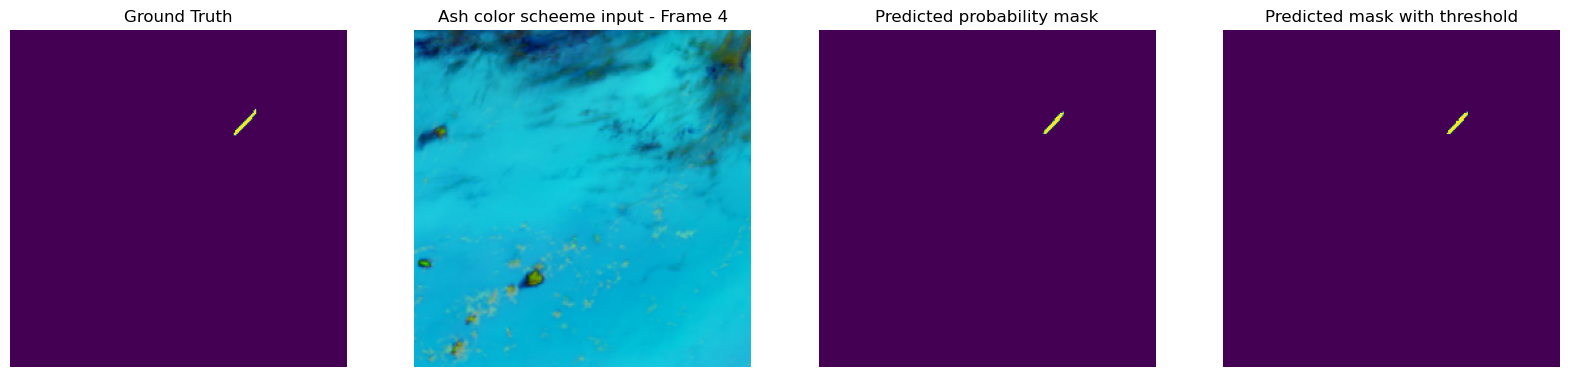

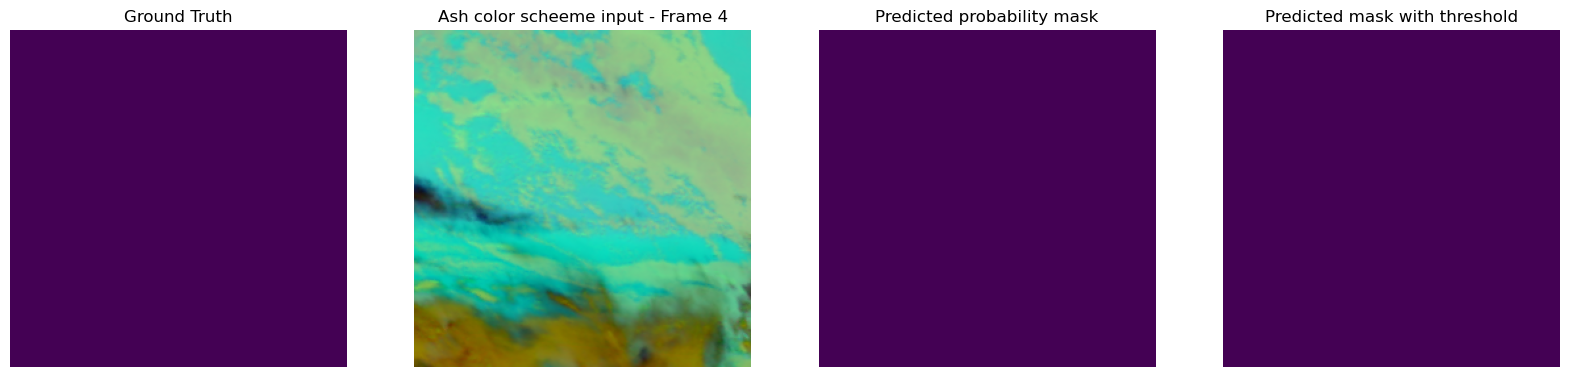

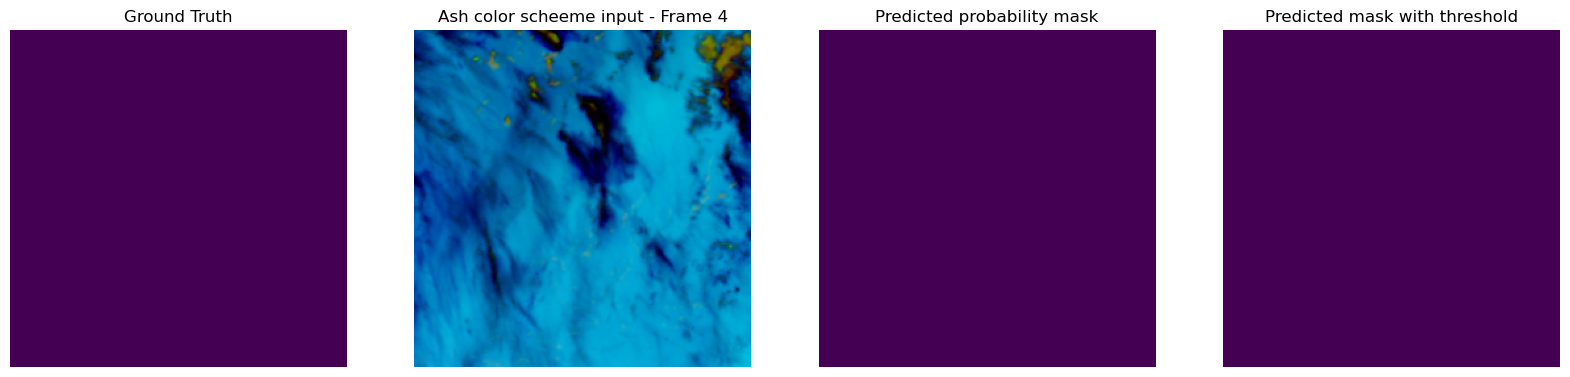

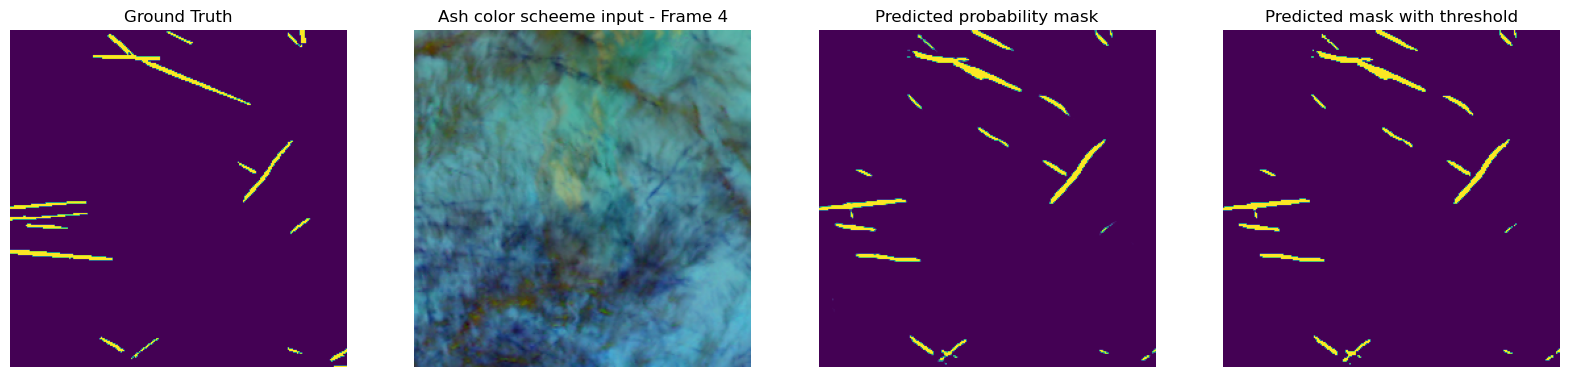

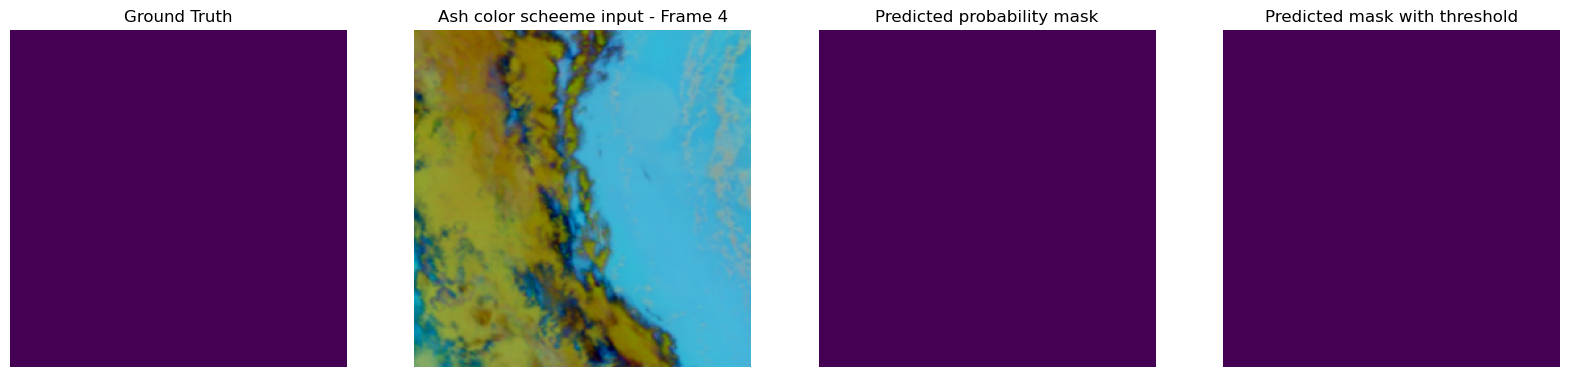

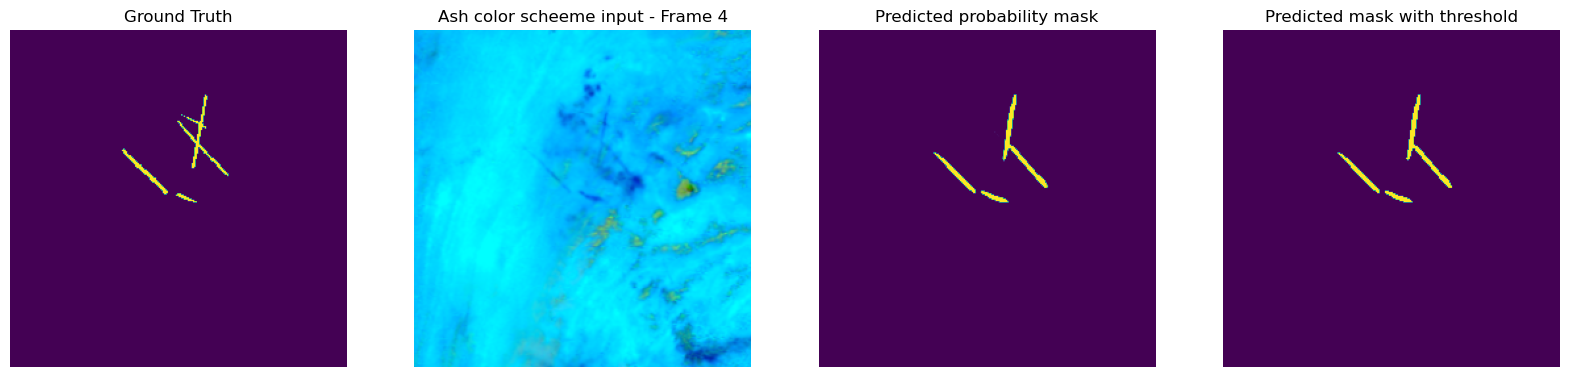

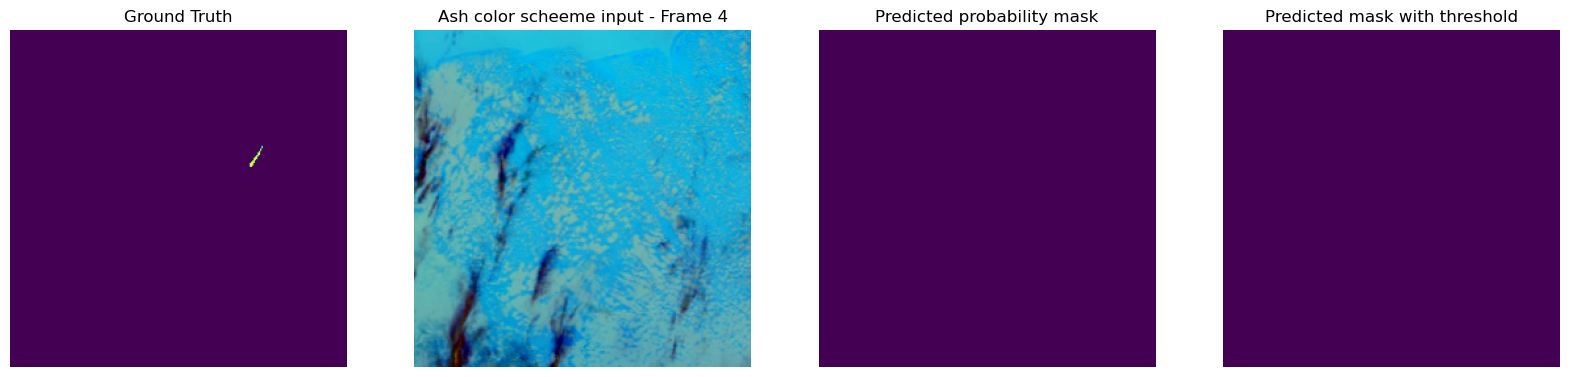

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

batches_to_show = 1
model.eval()

for i, data in enumerate(train_dl):
    images, mask = data
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())

    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    images = images.cpu()
        
    for img_num in range(0, images.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
        axes = axes.flatten()
        
        # Show groud trought 
        axes[0].imshow(mask[img_num, 0, :, :])
        axes[0].axis('off')
        axes[0].set_title('Ground Truth')
        
        # Show ash color scheme input image
        # axes[1].imshow( np.concatenate(
        #     (
        #     np.expand_dims(images[img_num, 0, :, :], axis=2),
        #     np.expand_dims(images[img_num, 1, :, :], axis=2),
        #     np.expand_dims(images[img_num, 2, :, :], axis=2)
        # ), axis=2))
        axes[1].imshow(images[img_num, :, :, :].permute(1, 2, 0))
        axes[1].axis('off')
        axes[1].set_title('Ash color scheeme input - Frame 4')

        # Show predicted mask
        axes[2].imshow(predicated_mask[img_num, 0, :, :], vmin=0, vmax=1)
        axes[2].axis('off')
        axes[2].set_title('Predicted probability mask')

        # Show predicted mask after threshold
        axes[3].imshow(predicated_mask_with_threshold[img_num, :, :])
        axes[3].axis('off')
        axes[3].set_title('Predicted mask with threshold')
        plt.show()
    
    if i + 1 >= batches_to_show:
        break

# Submission

In [27]:
# clear the cache

torch.cuda.empty_cache()

In [28]:
test_df = get_paths('test')

# cast record_id to int
test_df["record_id"] = test_df.record_id.astype(int)

test_ds = ContrailsDataset(
        test_df,
        train = False
    )

test_batch_size = 1

test_dl = DataLoader(test_ds, batch_size=test_batch_size, num_workers = configs.num_worers)

del test_ds

In [29]:
#source https://www.kaggle.com/code/inversion/contrails-rle-submission?scriptVersionId=128527711&cellId=4

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [30]:
submission = pd.read_csv(os.path.join(configs.base_dir, "sample_submission.csv"), index_col='record_id')

In [31]:
for i, images in enumerate(test_dl):
    
    
    image_id = torch.tensor(test_df.iloc[i]['record_id'])
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())
    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    current_mask = predicated_mask_with_threshold[:, :, :]
    current_image_id = image_id.item()
    submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [32]:
submission.head()

encoded_pixels
record_id                                                             
1000834164244036115  40966 3 41222 4 41480 4 41736 6 41994 5 42252 ...
1002653297254493116                                                  -

In [33]:
submission.to_csv('submission.csv')